In [59]:
import graph_tool.all as gt
import numpy as np
import itertools

In [313]:
def ZXGraph():
    g = gt.Graph(directed=False)
    g.set_fast_edge_removal()
    g.vp.type = g.new_vertex_property('int')
    g.vp.remove = g.new_vertex_property('bool')
    #g.set_vertex_filter(g.vp.remove, inverted=True)
    return g

def vcol(t):
    if t == 0: return 'black'
    if t == 1: return 'green'
    if t == 2: return 'red'
    return 'white'

def vcols(g):
    cols = g.new_vertex_property('string')
    for v in g.vertices():
        cols[v] = vcol(g.vp.type[v])
    return cols

def match_bialg(g, interior=False):
    for e in g.edges():
        v0 = e.source()
        v1 = e.target()
        v0t = g.vp.type[v0]
        v1t = g.vp.type[v1]
        if ((v0t == 1 and v1t == 2) or (v0t == 2 and v1t == 1)):
            if (
                not interior or (
                all([g.vp.type[n] == v1t for n in v0.all_neighbors()]) and
                all([g.vp.type[n] == v0t for n in v1.all_neighbors()]))
            ):
                return [v0,v1]
    return None

def bialg(g, match, check=False):
    v0 = match[0]
    v1 = match[1]
    v0t = g.vp.type[v0]
    v1t = g.vp.type[v1]

    if check:
        if not (
            g.edge(v0,v1) and
            ((v0t == 1 and v1t == 2) or
            (v0t == 2 and v1t == 1))
        ): return False
    
    n0 = [n for n in v0.all_neighbors() if n != v1]
    n1 = [n for n in v1.all_neighbors() if n != v0]
    
    # add dummy nodes around v0, v1 as necessary.
    for i in range(len(n0)):
        if (g.vp.type[n0[i]] != v1t):
            newv = g.add_vertex()
            g.vp.type[newv] = v1t
            
            g.remove_edge(g.edge(v0,n0[i]))
            g.add_edge_list([(n0[i], newv), (newv, v0)])
            n0[i] = newv
    
    for i in range(len(n1)):
        if (g.vp.type[n1[i]] != v0t):
            newv = g.add_vertex()
            g.vp.type[newv] = v0t
            g.remove_edge(g.edge(v1,n1[i].index))
            g.add_edge_list([(v1,newv),(newv,n1[i])])
            n1[i] = newv
    
    for s in n0:
        for t in n1:
            e = g.edge(s,t)
            if e: g.remove_edge(e)
            else: g.add_edge(s, t)
    
    # delete vertices at the end so we don't mess up indices. Note indices need to be deleted from
    # last to first.
    del_list = [v0,v1] + [v for v in n0 + n1 if v.in_degree() + v.out_degree() < 2]
    for v in reversed(sorted(del_list)):
        g.remove_vertex(v, fast=True)
    return True


def match_bialg_parallel(g, num=100):
    candidates = set(g.edges())
    ty = g.vp.type.a
    #return candidates
    i = 0
    m = []
    while (num == -1 or i < num) and len(candidates) > 0:
        e = candidates.pop()
        #if i >= num: break
        v0 = e.source()
        v1 = e.target()
        #if v0 in inv or v1 in inv: continue
        v0t = ty[int(v0)]
        v1t = ty[int(v1)]
        
        if ((v0t == 1 and v1t == 2) or (v0t == 2 and v1t == 1)):
            v0n = [n for n in v0.all_neighbors() if n != v1]
            v1n = [n for n in v1.all_neighbors() if n != v0]
            if (
                all([ty[int(n)] == v1t for n in v0n]) and
                all([ty[int(n)] == v0t for n in v1n])):
                i += 1
                for v in v0n:
                    candidates.discard(g.edge(v0,v))
                for v in v1n:
                    candidates.discard(g.edge(v1,v))
                m.append([int(v0),int(v1),list(map(int,v0n)),list(map(int,v1n))])
    return m

In [315]:
sz = 5 * 10**3
%time g = zigzag(sz)
%time m = match_bialg_parallel(g, num=-1)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 22 ms
CPU times: user 5.33 s, sys: 0 ns, total: 5.33 s
Wall time: 5.33 s


In [308]:
g = zigzag(10)
match_bialg_parallel(g)
ns = list(g.vertex(4).all_neighbors())
ns[0] == 6

True

In [271]:
#%time c = [(e[2],(e[0],e[1])) for e in g.get_edges()]
%time c = set(g.edges())

CPU times: user 10.3 s, sys: 5.72 s, total: 16 s
Wall time: 16 s


In [281]:
%time g.get_out_edges(10)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 481 µs


array([[      10,       12,        6],
       [      10,       13,  5000005],
       [      10,        8,        5],
       [      10,        9, 10000003]], dtype=uint64)

In [236]:
%time cs = set(range(len(em)))

CPU times: user 156 ms, sys: 141 ms, total: 297 ms
Wall time: 298 ms


In [112]:
sz = 1000000
g = gt.Graph(directed=False)
g.add_vertex(n=2*sz+4)
ty = g.new_vertex_property('int')
g.vertex_properties['type'] = ty
%time np.copyto(ty.a, [0,0] + [(x//2) % 2 + 1 for x in range(0,2*sz)] + [0,0])


CPU times: user 688 ms, sys: 15.6 ms, total: 703 ms
Wall time: 684 ms


In [256]:
def zigzag(sz):
    g = gt.Graph(directed = False)
    g.add_vertex(n=2*sz+4)
    ty = g.new_vertex_property('int') #, vals=[0,0] + [(x//2) % 2 + 1 for x in range(0,2*sz)] + [0,0])
    g.vertex_properties['type'] = ty
    ty.a = np.array([0,0] + [(x//2) % 2 + 1 for x in range(0,2*sz)] + [0,0])
    g.add_edge_list([(0,2),(1,3)])
    g.add_edge_list([(2*i,2*i+2) for i in range(1,sz)])
    g.add_edge_list([(2*i,2*i+3) for i in range(1,sz)])
    g.add_edge_list([(2*i+1,2*i+2) for i in range(1,sz)])
    g.add_edge_list([(2*i+1,2*i+3) for i in range(1,sz)])
    g.add_edge_list([(2*sz,2*sz+2),(2*sz+1,2*sz+3)])
    return g

In [12]:
g = ZXGraph()
%time g.add_vertex(n=10000000)
%time g.remove_vertex(9999, fast=True)

CPU times: user 234 ms, sys: 656 ms, total: 891 ms
Wall time: 888 ms
CPU times: user 15.6 ms, sys: 31.2 ms, total: 46.9 ms
Wall time: 38.1 ms


In [117]:
%time g = zigzag(1000000)
%time m = match_bialg(g, interior=True)
%time bialg(g, m)

CPU times: user 5.95 s, sys: 1.59 s, total: 7.55 s
Wall time: 7.53 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 992 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.79 ms


True

In [123]:
%time g1 = zigzag(5000)
def f():
    while True:
        m = match_bialg(g1, interior=True)
        if m: bialg(g1, m)
        else: break
%time f()

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 16.3 ms
CPU times: user 4.61 s, sys: 0 ns, total: 4.61 s
Wall time: 4.61 s


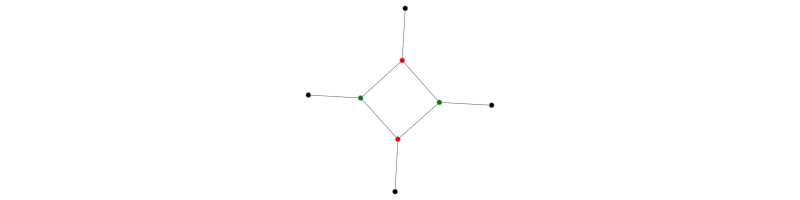

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9daf2a6080, at 0x7f9dafd52c88>

In [124]:
gt.graph_draw(g1, output_size=(800,200), vertex_size=5, vertex_fill_color=vcols(g1))

In [19]:
%time g = zigzag(10000000)

CPU times: user 36.1 s, sys: 15.3 s, total: 51.4 s
Wall time: 51.5 s
